In [1]:
import pandas as pd
d = pd.read_csv('student-por.csv', sep=';')
len(d)

649

In [3]:
# generate binary label(pass/fail) based on G1+G2+G3 (test grades, each 0-20pts); threshold for passing is sum>=30
d['pass'] = d.apply(lambda row: 1 if (row['G1']+row['G2']+row['G3'])>=35 else 0, axis=1)
d=d.drop(['G1', 'G2', 'G3'], axis=1)
d.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,1


In [6]:
#use one-hot encoding on categorical columns
d=pd.get_dummies(d, columns=['sex', 'school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 
                             'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])
d.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


In [16]:
# shuffle rows
d=d.sample(frac=1)
#split training and testing data
d_train = d[:500]
d_test = d[500:]

d_train_att = d_train.drop('pass', axis=1)
d_train_pass = d_train['pass']

d_test_att = d_test.drop('pass', axis=1)
d_test_pass = d_test['pass']

d_att=d.drop(['pass'], axis=1)
d_pass=d['pass']

#number of passing students in whole dataset:
import numpy as np
print("Passing: %d out of %d (%.2f%%)" % (np.sum(d_pass), len(d_pass), 100*float(np.sum(d_pass))/len(d_pass)))

Passing: 328 out of 649 (50.54%)


In [17]:
#fit a decision tress
from sklearn import tree

In [18]:
t=tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)
t=t.fit(d_train_att, d_train_pass)

In [19]:
tree.export_graphviz(t, out_file="student-performance.dot", label="all", impurity=False, proportion=True,
                    feature_names=list(d_train_att), class_names=["fail", "pass"], filled=True, rounded=True)

In [21]:
t.score(d_test_att, d_test_pass)

0.738255033557047

In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(t, d_att, d_pass, cv=5)
#show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: 0%.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 00.69 (+/- 0.12)


In [24]:
for max_depth in range(1, 20):
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, d_att, d_pass, cv=5)
    print("Max depth: %d, Accuracy:%0.2f(+/-%0.2f)" % (max_depth, scores.mean(), scores.std()*2))

Max depth: 1, Accuracy:0.64(+/-0.05)
Max depth: 2, Accuracy:0.69(+/-0.09)
Max depth: 3, Accuracy:0.69(+/-0.09)
Max depth: 4, Accuracy:0.69(+/-0.10)
Max depth: 5, Accuracy:0.69(+/-0.12)
Max depth: 6, Accuracy:0.68(+/-0.12)
Max depth: 7, Accuracy:0.68(+/-0.11)
Max depth: 8, Accuracy:0.67(+/-0.10)
Max depth: 9, Accuracy:0.67(+/-0.09)
Max depth: 10, Accuracy:0.67(+/-0.06)
Max depth: 11, Accuracy:0.67(+/-0.09)
Max depth: 12, Accuracy:0.66(+/-0.09)
Max depth: 13, Accuracy:0.66(+/-0.09)
Max depth: 14, Accuracy:0.66(+/-0.10)
Max depth: 15, Accuracy:0.65(+/-0.07)
Max depth: 16, Accuracy:0.65(+/-0.09)
Max depth: 17, Accuracy:0.64(+/-0.06)
Max depth: 18, Accuracy:0.65(+/-0.10)
Max depth: 19, Accuracy:0.63(+/-0.08)


In [26]:
depth_acc = np.empty((19,3), float)
i=0
for max_depth in range(1, 20):
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, d_att, d_pass, cv=5)
    depth_acc[i,0] = max_depth
    depth_acc[i,1] = scores.mean()
    depth_acc[i,2] = scores.std() * 2
    i +=1
    
depth_acc

array([[ 1.        ,  0.63798695,  0.05433695],
       [ 2.        ,  0.68732579,  0.08508294],
       [ 3.        ,  0.68571631,  0.08920045],
       [ 4.        ,  0.68571595,  0.10001713],
       [ 5.        ,  0.6902961 ,  0.12655429],
       [ 6.        ,  0.67946742,  0.1129285 ],
       [ 7.        ,  0.67808327,  0.08863843],
       [ 8.        ,  0.66576347,  0.08240495],
       [ 9.        ,  0.67499406,  0.08048488],
       [10.        ,  0.66730157,  0.07534544],
       [11.        ,  0.65957294,  0.09447849],
       [12.        ,  0.66876866,  0.10764486],
       [13.        ,  0.66577467,  0.08092659],
       [14.        ,  0.64725332,  0.0825473 ],
       [15.        ,  0.66425988,  0.08938131],
       [16.        ,  0.65197549,  0.09479119],
       [17.        ,  0.66114772,  0.07797398],
       [18.        ,  0.63951331,  0.08218778],
       [19.        ,  0.66268619,  0.07516147]])

In [27]:
import matplotlib.pyplot as plt

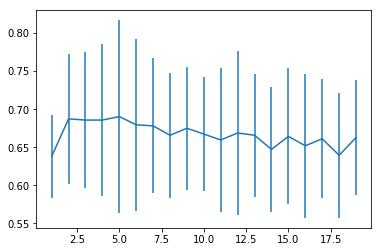

In [28]:
fig, ax = plt.subplots()
ax.errorbar(depth_acc[:,0], depth_acc[:,1], yerr=depth_acc[:,2])
plt.show()